# XgBoost with Dask

In [1]:
import dask
import xgboost
import dask_xgboost
import random
import pandas as pd
import dask.dataframe as dd
from dask import compute, persist
from dask.distributed import Client, progress
from dask_ml.datasets import make_classification
from dask_ml.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

client = Client(n_workers=4, threads_per_worker=1)
client

C:\Users\tleon\AppData\Local\Continuum\anaconda3\envs\dask\lib\site-packages\dask\array\random.py:27: FutureWarning: dask.array.random.doc_wraps is deprecated and will be removed in a future version
  FutureWarning,


Client Scheduler: tcp://127.0.0.1:54655,Cluster Workers: 4 Cores: 4 Memory: 16.99 GB


### Some data inspection and columns dropping

In [2]:
Path = '.....'

# Count the lines
num_lines = sum(1 for l in open(Path))
print("Total rows: ", num_lines)

# Sample size - in this case ~10%
size = int(num_lines / 10)
print("Sample size rows: ", size-1)

# The row indices to skip - make sure 0 is not included to keep the header!
skip_idx = random.sample(range(1, num_lines), num_lines - size)


# Create the dataframe from CSV
Data = pd.read_csv(Path,skiprows=skip_idx)
Data.drop(["RUT_CLIENTE","FECHA","B_MORA"], axis = 1, inplace = True)


Total rows:  90571
Sample size rows:  9056


In [3]:
# If user want to define columns
# Columns
cols = []

# Archive
'''
Archive could be of any type listed in: https://docs.dask.org/en/latest/dataframe-create.html
If the file is not in Local System please refer to: https://docs.dask.org/en/latest/remote-data-services.html
'''

Path = '......'

# Create the dataframe from CSV
Data = dd.read_csv(Path, assume_missing=True)

### Drop columns with no value, and Label with missing
Data = Data.drop(["RUT_CLIENTE","FECHA","B_MORA"], axis = 1)
Data = Data.dropna(subset=['BGI'])

#Label Data must be loaded or created
Label = Data[['BGI']]

#Remove Column Label from original Data
Data = Data.drop('BGI', axis=1)

In [18]:
print(Label.BGI.compute().unique())
print(Label.BGI.compute().count())

[1. 0.]
88245


### One Hot Encoding Categorical variables (optional)

In [5]:
Data_Dummy = dd.get_dummies(Data.categorize()).persist()

### Data split & Model Training

In [6]:
'''
If run previos block should use Data_Dummy
If not, run Data
'''

X_train, X_test, y_train, y_test = train_test_split(Data, Label, test_size=0.20)

params = {'objective': 'binary:logistic',
          'max_depth': 4,
          'eta': 0.01,
          'subsample': 0.5,
          'min_child_weight': 0.5}

bst = dask_xgboost.train(client, params, X_train, y_train, num_boost_round=10)

### Fetaures importance

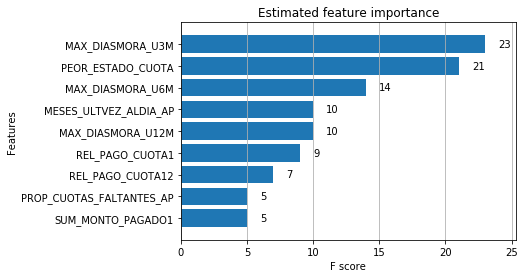

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

### Predict & Performance

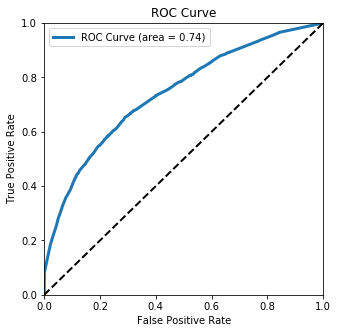

In [8]:
# Predict
y_hat = dask_xgboost.predict(client, bst, X_test).persist()

y_test, y_hat = dask.compute(y_test, y_hat)
fpr, tpr, _ = roc_curve(y_test, y_hat)

#ROC Curve
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()